<a href="https://colab.research.google.com/github/Geilson-Araujo/neural-networks/blob/master/flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What kind of flower is that?

An image classification task using the [Flowers Recognition](https://www.kaggle.com/alxmamaev/flowers-recognition) dataset from Kaggle.

The task consist in classifying flowers into five classes: daisy, tulip, rose, sunflower and dandelion, using a dataset from Kaggle.

In [3]:
!pip install --quiet -U kaggle
!apt install tree

In [5]:
from google.colab import files
files.upload()

# Downloading Flowers Recognition dataset from Kaggle

In [6]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from kaggle
!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip -q flowers-recognition.zip
!rm flowers-recognition.zip
!rm -r ./flowers/flowers/

 98% 441M/450M [00:13<00:00, 36.7MB/s]
100% 450M/450M [00:13<00:00, 35.0MB/s]


In [7]:
# Check files
!tree --filelimit 10 ./flowers/

./flowers/
├── daisy [769 entries exceeds filelimit, not opening dir]
├── dandelion [1055 entries exceeds filelimit, not opening dir]
├── rose [784 entries exceeds filelimit, not opening dir]
├── sunflower [734 entries exceeds filelimit, not opening dir]
└── tulip [984 entries exceeds filelimit, not opening dir]

5 directories, 0 files


# Importing libraries

In [8]:
import os
import shutil

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

torch.manual_seed(0)
np.random.seed(0)

# Preparing training and validation datasets

In [9]:
path = {
    'root'  : './flowers/',
    'train' : './flowers/training',
    'valid' : './flowers/validation',   
}

if os.path.isdir(path['root']):

    try:

        os.mkdir(os.path.join(path['root'], 'training'))
        os.mkdir(os.path.join(path['root'], 'validation'))

        labels = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']    

        for label in labels:

            os.mkdir(os.path.join(path['root'], 'training', label))
            os.mkdir(os.path.join(path['root'], 'validation', label))

            img_names = [img_name for img_name 
                         in os.listdir(os.path.join(path['root'], label))
                         if os.path.splitext(img_name)[-1] == '.jpg']

            np.random.shuffle(img_names)
            split_indices = int(len(img_names) * 0.8)

            train_images = img_names[:split_indices] # 80% of the data for training
            valid_images = img_names[split_indices:] # 20% of the data for validation

            for img_name in train_images:
                scr = os.path.join(path['root'], label, img_name)
                dst = os.path.join(path['root'], 'training', label, img_name)
                shutil.copy(scr, dst)

            print('Class:', label, ' - Taining sample:', len(train_images))

            for img_name in valid_images:
                scr = os.path.join(path['root'], label, img_name)
                dst = os.path.join(path['root'], 'validation', label, img_name)
                shutil.copy(scr, dst)

            print('Class:', label, ' - Validation sample:', len(valid_images))
            print('---')

    except FileExistsError as e:
        print(e)

Class: daisy Taining sample: 615
Class: daisy Validation sample: 154
---
Class: dandelion Taining sample: 841
Class: dandelion Validation sample: 211
---
Class: rose Taining sample: 627
Class: rose Validation sample: 157
---
Class: sunflower Taining sample: 587
Class: sunflower Validation sample: 147
---
Class: tulip Taining sample: 787
Class: tulip Validation sample: 197
---


In [10]:
# Check training set
!tree --filelimit 10 ./flowers/training/

./flowers/training/
├── daisy [615 entries exceeds filelimit, not opening dir]
├── dandelion [841 entries exceeds filelimit, not opening dir]
├── rose [627 entries exceeds filelimit, not opening dir]
├── sunflower [587 entries exceeds filelimit, not opening dir]
└── tulip [787 entries exceeds filelimit, not opening dir]

5 directories, 0 files


In [11]:
# Check validation set
!tree --filelimit 10 ./flowers/validation/

./flowers/validation/
├── daisy [154 entries exceeds filelimit, not opening dir]
├── dandelion [211 entries exceeds filelimit, not opening dir]
├── rose [157 entries exceeds filelimit, not opening dir]
├── sunflower [147 entries exceeds filelimit, not opening dir]
└── tulip [197 entries exceeds filelimit, not opening dir]

5 directories, 0 files


In [12]:
# Define some parameters and hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

args = {
    'device'        : device,
    'img_size'      :    224,
    'batch_size'    :    128,
    'num_workers'   :      4,
    'learning_rate' :    0.1,
    'momentum'      :    0.9,
    'weight_decay'  :   1e-4, 
    'epochs'        :     30,
    'mode'          :  'max', 
    'patience'      :      3,
    'best_model'    :      0, 
    }

# Transformations and data augmentation

In [13]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = {
    'train' : transforms.Compose([
              transforms.Resize((args['img_size'], args['img_size'])),
              transforms.RandomCrop((args['img_size'], args['img_size'])),              
              transforms.RandomHorizontalFlip(),
              transforms.RandomRotation(10),
              transforms.RandomAffine(0,shear=10,scale=(0.8, 1.2)),
              transforms.ColorJitter(brightness=0.2,contrast=0.2,
                                     saturation=0.2),        
              transforms.RandomGrayscale(),        
              transforms.ToTensor(),
              normalize,
              ]),

    'valid' : transforms.Compose([
              transforms.Resize((args['img_size'], args['img_size'])),
              transforms.ToTensor(),
              normalize,
              ])
              }

In [14]:
train_set = torchvision.datasets.ImageFolder(root=path['train'],
                                             transform=transform['train'])
valid_set = torchvision.datasets.ImageFolder(root=path['valid'],
                                             transform=transform['valid'])

In [15]:
# Check if data is balanced
train_images_per_class = {}

for class_name in train_set.classes:
    img_path  = os.path.join(path['train'], class_name)
    img_names = [img_name for img_name in os.listdir(img_path)
                 if os.path.splitext(img_name)[-1] == '.jpg']

    train_images_per_class[class_name] = len(img_names)

valid_images_per_class = {}

for class_name in valid_set.classes:
    img_path  = os.path.join(path['valid'], class_name)
    img_names = [img_name for img_name in os.listdir(img_path)
                 if os.path.splitext(img_name)[-1] == '.jpg']

    valid_images_per_class[class_name] = len(img_names)

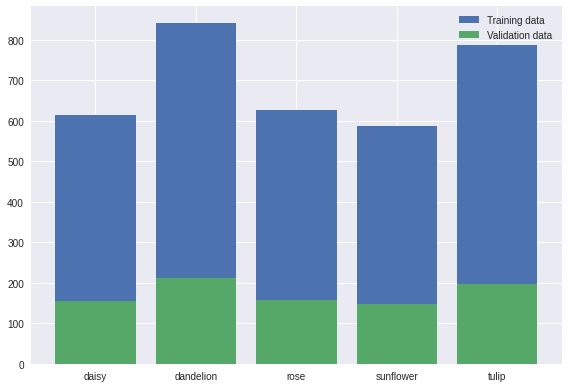

In [16]:
plt.style.use('seaborn')
plt.bar(*zip(*train_images_per_class.items()), label='Training data')
plt.bar(*zip(*valid_images_per_class.items()), label='Validation data')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [17]:
print(f'Total of training set images: {pd.Series(train_images_per_class).sum()}',
      '---', sep='\n')

pd.Series(train_images_per_class)

Total of training set images: 3457
---


daisy        615
dandelion    841
rose         627
sunflower    587
tulip        787
dtype: int64

In [18]:
print(f'Total of validation set images: {pd.Series(valid_images_per_class).sum()}',
      '---', sep='\n')

pd.Series(valid_images_per_class)

Total of validation set images: 866
---


daisy        154
dandelion    211
rose         157
sunflower    147
tulip        197
dtype: int64

# Preparing dataloader

In [19]:
train_loader = torch.utils.data.DataLoader(train_set, args['batch_size'],
                                           shuffle=True,
                                           num_workers=args['num_workers'])

valid_loader = torch.utils.data.DataLoader(valid_set, args['batch_size'],
                                           shuffle=True,
                                           num_workers=args['num_workers'])

# Visualizing a few images

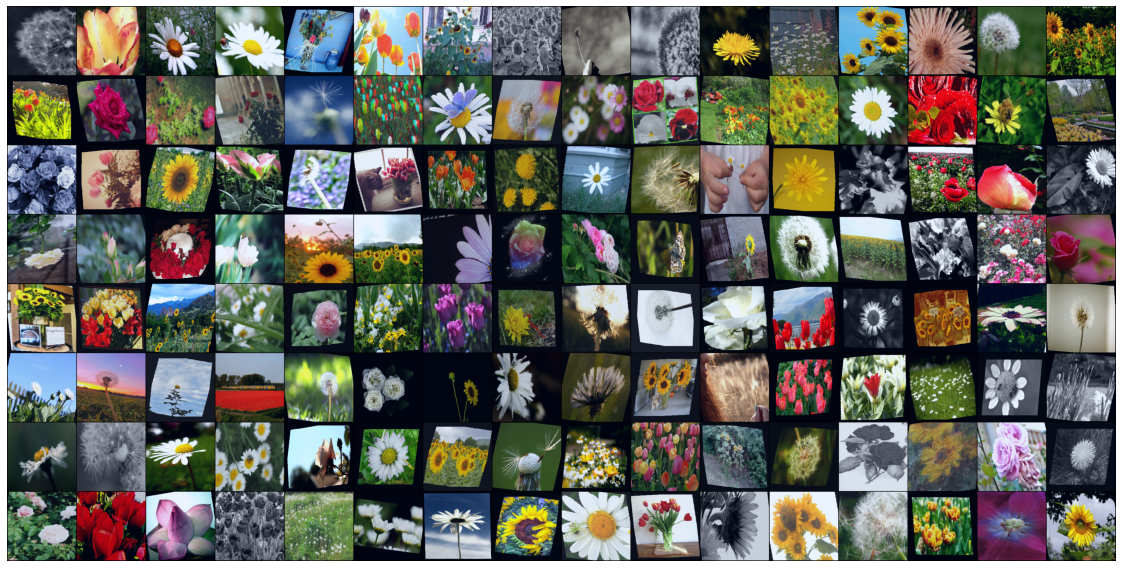

In [20]:
images, labels = next(iter(train_loader))

grid = torchvision.utils.make_grid(images, nrow=16, normalize=True)
plt.figure(figsize=(17, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.tight_layout()
plt.show()

# Creating the model

In [22]:
class ResNet50Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pretrained_model = torchvision.models.resnet50(pretrained=True)
        
        # Freeze the convolution base of ResNet50
        for param in self.pretrained_model.parameters():
            param.requires_grad = False

        # Change the last full connected layer
        self.pretrained_model.fc = nn.Linear(in_features=2048, out_features=5)

    def forward(self, image):        
        output = self.pretrained_model(image)
        
        return output


In [23]:
classifier = ResNet50Classifier().to(args['device']) # GPU computing

criterion  = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args['learning_rate'],
                       weight_decay=args['weight_decay'])

scheduler  = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=args['mode'],
                                                  patience=args['patience'],
                                                  verbose=True)

# Training the model

In [24]:
%%time
classifier.train()

history = {
    'train_loss': [],
    'train_acc' : [],
    'valid_loss': [],
    'valid_acc' : [],
    }

for epoch in range(1, args['epochs'] + 1):

    train_loss = 0
    train_acc  = 0
    
    for batch in train_loader:

        images = batch[0].to(args['device'])
        labels = batch[1].to(args['device'])

        # Zero grad
        optimizer.zero_grad()

        # Forward
        outputs  = classifier(images)
        loss     = criterion(outputs, labels)
        _, preds = outputs.max(dim=1)

        # Backward
        loss.backward() 
        optimizer.step()

        train_loss += loss.item()
        train_acc  += (preds == labels).sum().item()

    train_loss /= len(train_set)
    train_acc  /= len(train_set)

    print(f'[Epoch {epoch}/{args["epochs"]}]', 
          f'train_loss: {train_loss:7.4f}',
          f'train_acc: {train_acc:.2%}', sep='\t')
     
    # Validation  
    classifier.eval()

    with torch.no_grad():
        
        valid_loss = 0
        valid_acc  = 0

        for batch in valid_loader:

            images = batch[0].to(args['device'])
            labels = batch[1].to(args['device'])
            
            outputs  = classifier(images)
            loss     = criterion(outputs, labels)
            _, preds = outputs.max(dim=1)        

            valid_loss += loss.item()
            valid_acc  += (preds == labels).sum().item()

        valid_loss /= len(valid_set)
        valid_acc  /= len(valid_set)

        print(f'[Epoch {epoch}/{args["epochs"]}]',
              f'valid_loss: {valid_loss:7.4f}',
              f'valid_acc: {valid_acc:.2%}', sep='\t')

        scheduler.step(metrics=valid_acc)
        
        if valid_acc > args['best_model']:
            args['best_model'] = valid_acc
            print(f'Best model: {args["best_model"]:.2%}')

        print('---')

    history['train_loss'].append(train_loss)
    history['train_acc' ].append(train_acc)
    history['valid_loss'].append(valid_loss)
    history['valid_acc' ].append(valid_acc)

[Epoch 1/30]	train_loss:  0.2543	train_acc: 44.23%
[Epoch 1/30]	valid_loss:  0.0902	valid_acc: 65.70%
Best model: 65.70%
---
[Epoch 2/30]	train_loss:  0.0770	train_acc: 66.68%
[Epoch 2/30]	valid_loss:  0.0398	valid_acc: 79.91%
Best model: 79.91%
---
[Epoch 3/30]	train_loss:  0.0298	train_acc: 82.09%
[Epoch 3/30]	valid_loss:  0.0722	valid_acc: 72.06%
---
[Epoch 4/30]	train_loss:  0.0889	train_acc: 73.13%
[Epoch 4/30]	valid_loss:  0.0354	valid_acc: 81.64%
Best model: 81.64%
---
[Epoch 5/30]	train_loss:  0.0286	train_acc: 81.98%
[Epoch 5/30]	valid_loss:  0.0731	valid_acc: 69.28%
---
[Epoch 6/30]	train_loss:  0.0529	train_acc: 74.92%
[Epoch 6/30]	valid_loss:  0.0344	valid_acc: 80.37%
---
[Epoch 7/30]	train_loss:  0.0257	train_acc: 83.25%
[Epoch 7/30]	valid_loss:  0.0245	valid_acc: 84.87%
Best model: 84.87%
---
[Epoch 8/30]	train_loss:  0.0199	train_acc: 86.06%
[Epoch 8/30]	valid_loss:  0.0239	valid_acc: 85.10%
Best model: 85.10%
---
[Epoch 9/30]	train_loss:  0.0165	train_acc: 85.71%
[Epoch

# Final results

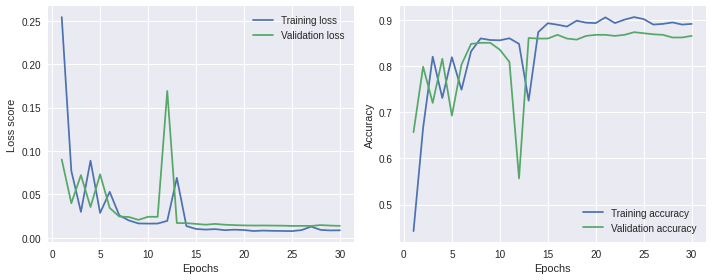

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(range(1, args['epochs'] + 1), history['train_loss'],
           label='Training loss')
ax[0].plot(range(1, args['epochs'] + 1), history['valid_loss'],
           label='Validation loss')
ax[0].set(xlabel='Epochs', ylabel='Loss score')
ax[0].legend()
ax[1].plot(range(1, args['epochs'] + 1), history['train_acc' ],
           label='Training accuracy')
ax[1].plot(range(1, args['epochs'] + 1), history['valid_acc' ],
           label='Validation accuracy')
ax[1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

# Visualizing the model predictions

In [30]:
def show_images(images, labels, preds):

    classes = valid_set.classes

    fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(14, 5),
                             subplot_kw={'xticks': [], 'yticks': []}) 


    for i, (ax, img) in enumerate(zip(axes.flat, images)):
        
        img  = img.permute(1, 2, 0)
        img  = img.data.cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std  = np.array([0.229, 0.224, 0.225])
        img  = (img * std) + mean
        img  = np.clip(img, 0, 1)
        
        ax.imshow(img)
        
        # Label
        ax.set_title(f'{classes[labels[i]]}', size='x-large')
        
        # Predictions in green are correct
        color = 'green' if preds[i] == labels[i] else 'red'
        ax.set_xlabel(f'{classes[preds[i]]}', color=color, size='x-large')           
    
    plt.tight_layout()

    plt.savefig('flowers.jpg', quality=95, optimize=True, format='jpg',
            bbox_inches='tight')    

    plt.show()

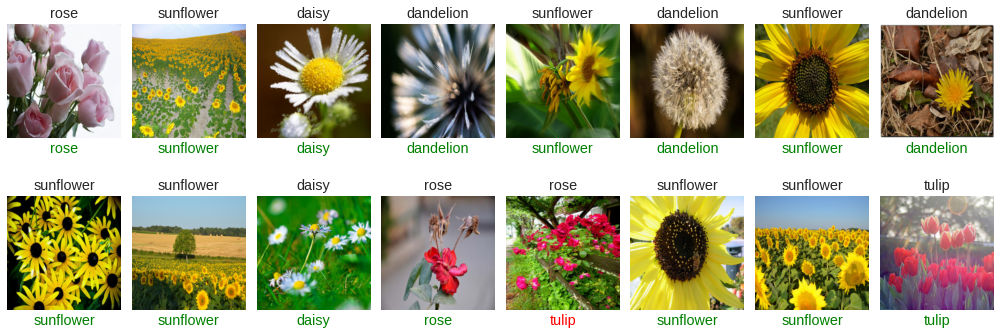

In [38]:
classifier.eval()
batch    = next(iter(valid_loader))
images   = batch[0].to(args['device'])
labels   = batch[1].to(args['device'])

outputs  = classifier(images)
_, preds = torch.max(outputs, 1)

show_images(images, labels, preds)